# Advanced Atomistic Simulations with Machine Learning Interatomic Potentials

Author: Vignesh Sathyaseelan (vsathyas@purdue.edu)

This notebook demonstrates how to integrate a machine-learned interatomic potential (MLIP) with ASE for:
- Geometry optimizations
- Molecular dynamics (MD) simulations
- Nudged Elastic Band (NEB) calculations
- Adsorption Free Energy calculations

Ensure you have an MLIP potential loaded in you envronment (MACE) and example structures (`initial.xyz`, `final.xyz`) in your working directory.

RUN THIS: !pip install mace-torch torch-dftd


## 1. Setup & Imports

In [9]:
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

from ase import Atoms, units  # Import core ASE classes: Atoms for atomic structures, units for physical constants
from ase.io import read, write  # Import functions to read and write atomic structures
from ase.visualize import view  # Import function to interactively view structures
from ase.visualize.plot import plot_atoms  # Import function to plot atomic structures using Matplotlib

## 2. Geometry Optimization with EMT (Baseline)
We start by using the classical EMT potential for initial geometry optimization.
This provides a quick baseline before switching to more accurate MLIPs.

      Step     Time          Energy          fmax
BFGS:    0 13:56:14        4.028091        8.048738
BFGS:    1 13:56:14        2.449931        3.186848
BFGS:    2 13:56:14        2.017079        1.749374
BFGS:    3 13:56:14        1.886456        0.998144
BFGS:    4 13:56:14        1.824383        1.013382
BFGS:    5 13:56:14        1.732153        1.237173
BFGS:    6 13:56:14        1.703410        0.277504


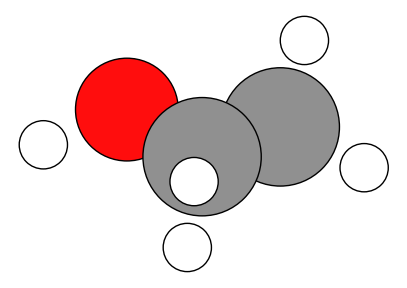

In [11]:
# Optimize with EMT
from ase.optimize import BFGS  # Import the BFGS optimizer from ASE
from ase.calculators.emt import EMT  # Import the EMT calculator (Effective Medium Theory)

# Read a structure and assign EMT calculator
atoms = read('initial.xyz')  # Load the initial atomic structure from an XYZ file

atoms.calc = EMT()  # Set the EMT calculator for the atoms
opt = BFGS(atoms, trajectory='emt_opt.traj')  # Set up the BFGS optimizer and record the trajectory
opt.run(fmax=0.5)  # Run the optimization until the maximum force is below 0.5 eV/Å

write('initial_optimized.xyz', atoms)  # Save the optimized structure to a new XYZ file
view(atoms)  # Optionally, open an interactive viewer to inspect the structure

fig, ax = plt.subplots(figsize=(5, 5))  # Create a matplotlib figure and axis
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))  # Plot the atoms with no rotation
ax.axis('off')  # Hide axis for better visualization
plt.show()  # Display the plot

## 3. Load MLIP Model into ASE

In [12]:
# Load your trained MLIP potential
import torch
import torch._dynamo
torch._dynamo.config.suppress_errors = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from mace.calculators import mace_mp

mlip_calc = mace_mp(model="medium", dispersion=True, default_dtype="float64", device='cpu')


Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections


## 4. Geometry Optimization with MLIP
Now we switch to a machine-learned interatomic potential (MLIP) for higher accuracy.

      Step     Time          Energy          fmax
BFGS:    0 13:57:08      -47.269334        0.239886


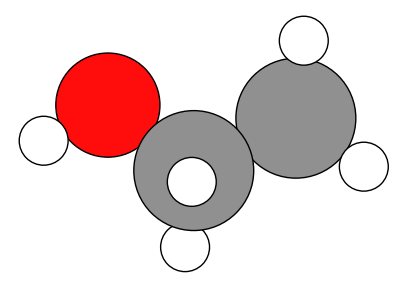

In [13]:
# Optimize with EMT
from ase.optimize import BFGS

# Read a structure and assign EMT calculator
atoms = read('initial.xyz')

atoms.calc = mlip_calc
opt = BFGS(atoms, trajectory='emt_opt.traj')
opt.run(fmax=0.5)

write('initial_optimized.xyz', atoms)
view(atoms)

fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))
ax.axis('off') 
plt.show()


## 5. Molecular Dynamics (MD) Simulation Example

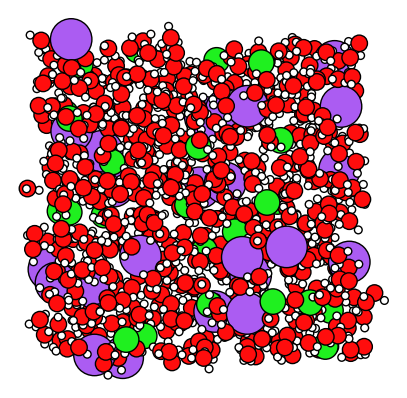

Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections


True

In [ ]:
# Import necessary modules from ASE for molecular dynamics and plotting
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution  # For initializing velocities
from ase.md.langevin import Langevin  # Langevin thermostat for MD
from ase.md import MDLogger  # Logger for MD simulations

# Read the atomic structure from an XYZ file
atoms = read('NaClWater.xyz')
temp = 1000 #K  # Set the simulation temperature in Kelvin

# Visualize the structure
fig, ax = plt.subplots(figsize=(5, 5))  # Create a matplotlib figure and axis
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))  # Plot the atoms with no rotation
ax.axis('off')  # Hide axis for better visualization
plt.show()  # Display the plot
view(atoms)  # Optionally, open an interactive viewer

# Set up the calculator (potential) for the atoms
atoms.calc = mace_mp(model="medium", dispersion=True, default_dtype="float64", device='cpu')
MaxwellBoltzmannDistribution(atoms, temperature_K=temp)  # Initialize velocities according to the Maxwell-Boltzmann distribution

# Set up the Langevin dynamics
# 0.5 fs time step, target temperature, and friction coefficient
# Friction is set as 0.01 / fs
# units.fs is the femtosecond unit from ASE
# The Langevin thermostat keeps the system at the desired temperature

# Create the Langevin dynamics object
# To use VelocityVerlet instead of Langevin, uncomment the following line:
# from ase.md.verlet import VelocityVerlet
# from ase.md.verlet import VelocityVerlet
# dyn = VelocityVerlet(atoms, 0.5 * units.fs)
dyn = Langevin(atoms, 0.5 * units.fs, temperature_K=temp, friction=0.01 / units.fs)
# Attach a function to write the trajectory to an XYZ file every step
dyn.attach(lambda: write('md.xyz', atoms.copy(), append=True), interval=1)
# Attach a logger to record MD information every step
dyn.attach(MDLogger(dyn, atoms, "md.log"), interval=1)
# Run the MD simulation for 10 steps
dyn.run(10)


## 6. Setting up NEB Calculations. Precondition the Initial and Final Image. (Conformatinal Sampling)

      Step     Time          Energy          fmax
BFGS:    0 14:03:26      -47.269334        0.239886
Potential ENergy: -47.2693335450208


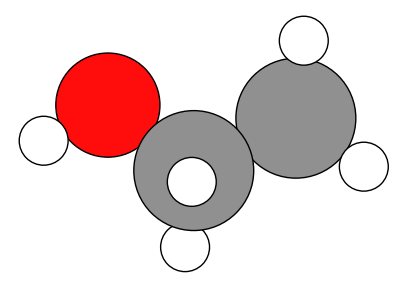

      Step     Time          Energy          fmax
BFGS:    0 14:03:27      -45.764443        0.205591
Potential ENergy: -45.76444338531978


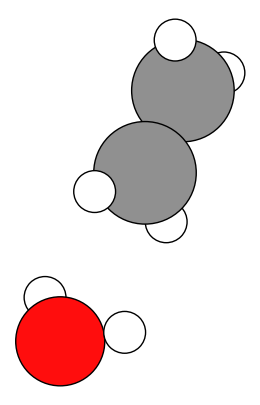

In [14]:
# Read initial structure 
atoms = read('initial.xyz')  # Load the initial atomic structure from an XYZ file
atoms.calc = mlip_calc  # Set the machine learning interatomic potential calculator

# Run a BFGS optimization
opt = BFGS(atoms, trajectory='opt.traj')  # Set up the BFGS optimizer and record the trajectory
opt.run(fmax=0.5)  # Run the optimization until the maximum force is below 0.5 eV/Å

# Save and view the optimized structure
write('initial_optimized.xyz', atoms)  # Save the optimized structure to a new XYZ file

# Calculate the potential energy of the optimized structure
print(f"Potential ENergy: {atoms.get_potential_energy()}")  # Print the potential energy

# Visualize the optimized structure
fig, ax = plt.subplots(figsize=(5, 5))  # Create a matplotlib figure and axis
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))  # Plot the atoms with no rotation
ax.axis('off')  # Hide axis for better visualization
plt.show()  # Display the plot

# Read final structure 
atoms = read('final.xyz')  # Load the final atomic structure from an XYZ file
atoms.calc = mlip_calc  # Set the machine learning interatomic potential calculator

# Run a BFGS optimization
opt = BFGS(atoms, trajectory='opt.traj')  # Set up the BFGS optimizer and record the trajectory
opt.run(fmax=0.5)  # Run the optimization until the maximum force is below 0.5 eV/Å

# Save and view the optimized structure
write('final_optimized.xyz', atoms)  # Save the optimized structure to a new XYZ file

# Calculate the potential energy of the optimized structure
print(f"Potential ENergy: {atoms.get_potential_energy()}")  # Print the potential energy

# Visualize the optimized structure
fig, ax = plt.subplots(figsize=(5, 5))  # Create a matplotlib figure and axis
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))  # Plot the atoms with no rotation
ax.axis('off')  # Hide axis for better visualization
plt.show()  # Display the plot

## 7. Using the Kabsch algorithm to align and precondition your initial and final images is essential for obtaining accurate, physically meaningful NEB results. It removes artifacts due to rotation and translation, ensuring that the computed reaction path and energy barrier are correct.

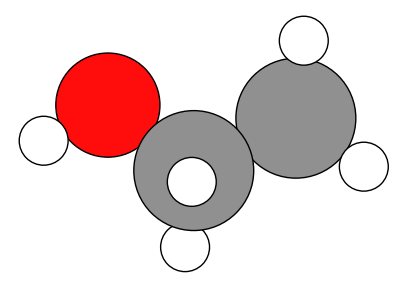

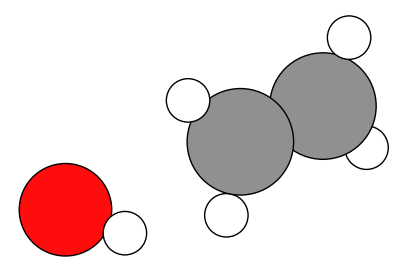

In [19]:
# Load initial and final states
initial = read('initial_optimized.xyz')  # Read the optimized initial structure
final = read('final_optimized.xyz')      # Read the optimized final structure

# Align final to initial (minimize rotation/translation)
# The Kabsch algorithm is used here to optimally align the final structure to the initial structure.
# This removes any overall rotation and translation between the two structures, ensuring that
# the interpolation between images (for NEB) is physically meaningful and does not include
# artificial rotation or translation. This preconditioning step is crucial for obtaining a
# realistic minimum energy path in NEB calculations.

def align_structure_kabsch(mobile, target):
    # Center both structures at their respective centers of mass
    P = target.get_positions() - target.get_center_of_mass()  # Center target
    Q = mobile.get_positions() - mobile.get_center_of_mass()  # Center mobile

    # Compute the covariance matrix between the two sets of positions
    C = np.dot(Q.T, P)

    # Perform Singular Value Decomposition (SVD) to find the optimal rotation
    V, S, Wt = np.linalg.svd(C)
    d = np.sign(np.linalg.det(np.dot(V, Wt)))  # Correct for possible reflection
    U = np.dot(V, np.dot(np.diag([1,1,d]), Wt))  # Construct the rotation matrix

    # Rotate and translate the mobile structure to best match the target
    aligned_positions = np.dot(Q, U)
    aligned_positions += target.get_center_of_mass()
    mobile.set_positions(aligned_positions)
    return

# Align the final structure to the initial structure before NEB interpolation
# This ensures that the NEB path is not affected by arbitrary rotation or translation.
final = final.copy()  # Work on a copy to avoid modifying the original
align_structure_kabsch(final, initial)  # Align final structure to initial

fig, ax = plt.subplots(figsize=(5, 5))  # Create a matplotlib figure and axis
plot_atoms(initial, ax, rotation=('0x,0y,0z'))  # Plot the atoms with no rotation
ax.axis('off')  # Hide axis for better visualization
plt.show()  # Display the plot


fig, ax = plt.subplots(figsize=(5, 5))  # Create a matplotlib figure and axis
plot_atoms(final, ax, rotation=('0x,0y,0z'))  # Plot the atoms with no rotation
ax.axis('off')  # Hide axis for better visualization
plt.show()  # Display the plot



## 7. Nudged Elastic Band (NEB) Calculation

Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with

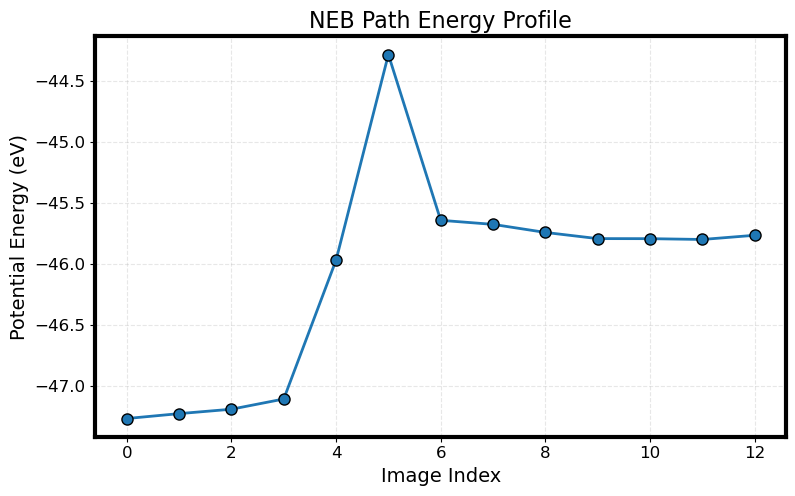

<Popen: returncode: None args: ['/opt/anaconda3/bin/python', '-m', 'ase', 'g...>

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.9/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/opt/anaconda3/lib/python3.9/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py", line 527, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on closed file.


In [21]:
from ase.mep import NEB 

# Create intermediate images for the NEB path
images = [initial]  # Start the images list with the initial structure
n_images = 11       # Number of intermediate images (not counting initial and final)
for i in range(n_images):
    img = initial.copy()  # Create a copy for each intermediate image
    images.append(img)
images.append(final)  # Add the final structure as the last image

# Set up the NEB (Nudged Elastic Band) object
neb = NEB(images, climb=True)  # Create NEB object; 'climb=True' enables the climbing image for better saddle point location
neb.interpolate(method='idpp')  # Interpolate images using the IDPP method for a more realistic initial path

# Save NEB images before optimization (for visualization or debugging)
for idx, img in enumerate(images):
    write(f'neb_image_{idx}.xyz', img)  # Save each image to an XYZ file

# Assign a calculator to each image (required for energy and force calculations)
for img in images:
    img.calc = mace_mp(model="medium", dispersion=True, default_dtype="float64", device='cpu')  # Replace with your MLIP calculator

# Optimize the NEB path using the BFGS optimizer
optimizer = BFGS(neb)  # Set up the BFGS optimizer for the NEB object
optimizer.run(fmax=0.5)  # Run the optimization until the maximum force is below 0.5 eV/Å

# Save NEB images after optimization (optional, currently commented out)
# for idx, img in enumerate(images):
#     write(f'neb_image_{idx}.xyz', img)

# Extract energies from each image and plot the NEB energy profile
energies = [img.get_potential_energy() for img in images]  # Get the potential energy for each image
plt.figure(figsize=(8, 5))  # Create a new figure for plotting

# Plot the energy profile with larger markers and thicker lines for clarity
plt.plot(range(len(energies)), energies, 'o-', linewidth=2, markersize=8, color='tab:blue', markeredgecolor='black')

# Set axis labels and title with larger font sizes
plt.xlabel('Image Index', fontsize=14)
plt.ylabel('Potential Energy (eV)', fontsize=14)
plt.title('NEB Path Energy Profile', fontsize=16)

# Customize the grid and axis spines for better aesthetics
plt.grid(True, alpha=0.3, linestyle='--')  # Add a lighter, dashed grid
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(3)  # Make axis lines thicker

# Improve tick label font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

view(images)  # Optionally, view all NEB images interactively

## 8. Absorption Energy Calculation Example

Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections


/opt/anaconda3/lib/python3.9/site-packages/torch_dftd/torch_dftd3_calculator.py:98: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  cell: Optional[Tensor] = torch.tensor(


Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections


/opt/anaconda3/lib/python3.9/site-packages/ase/io/extxyz.py:311: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


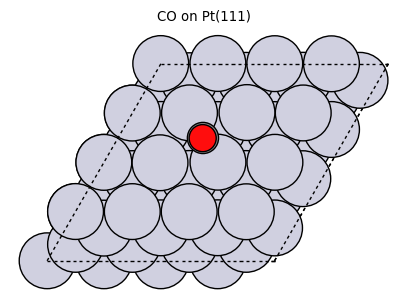


Adsorption Energy (E_ads) = -1.9359 eV


In [22]:
from ase.build import molecule, surface, add_adsorbate  # Tools to build molecules, surfaces, and add adsorbates
from ase.constraints import FixAtoms  # To fix certain atoms during optimization

def optimize_structure(atoms, output_name):
    # Assign a machine learning interatomic potential calculator to the atoms
    atoms.calc = mace_mp(model="medium", dispersion=True, default_dtype="float64", device='cpu')
    # Set up the BFGS optimizer, saving trajectory and log files
    opt = BFGS(atoms, trajectory=output_name + '.xyz', logfile=output_name + '.log')
    # Run the optimization until the maximum force is below 0.05 eV/Å
    opt.run(fmax=0.05)
    # Save the optimized structure to an XYZ file
    write(output_name + '.xyz', atoms)
    return atoms

def plot_structure(atoms, title):
    # Plot the atomic structure using matplotlib and ASE's plot_atoms
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_atoms(atoms, ax, rotation=('0x,0y,0z'))
    ax.set_title(title)
    ax.axis('off')
    plt.show()

# 1. Build and optimize the adsorbate (CO molecule)
adsorbate = molecule('CO')  # Create a CO molecule
adsorbate.center(vacuum=5.0)  # Center the molecule in a box with 5 Å vacuum
ads = optimize_structure(adsorbate, 'adsorbate_optimized')  # Optimize the CO molecule

# 2. Build and optimize the clean Pt(111) surface
slab = surface('Pt', (1, 1, 1), layers=4, vacuum=5.0)  # Build a 4-layer Pt(111) slab
slab = slab.repeat((2, 2, 1))  # Replicate the slab 2x2 in-plane for a larger surface
slab.center(axis=2, vacuum=5.0)  # Center the slab with vacuum above and below

# Fix the bottom layer of the slab to mimic bulk behavior during optimization
constraint = FixAtoms(indices=[atom.index for atom in slab if atom.position[2] < slab.positions[:,2].mean()])
slab.set_constraint(constraint)
surf = optimize_structure(slab, 'surface_optimized')  # Optimize the clean surface

# 3. Add CO adsorbate to the surface
slab_ads = slab.copy()  # Copy the slab for adsorption

# Find the top layer atoms (highest z) to determine where to place the adsorbate
z_positions = slab.positions[:, 2]
z_max = z_positions.max()
tolerance = 0.5  # Angstroms

# Get indices of atoms in the top layer (within tolerance of z_max)
top_layer_indices = [i for i, z in enumerate(z_positions) if abs(z - z_max) < tolerance]

# Compute the average XY position of the top layer (center of the surface)
xy_positions = slab.positions[top_layer_indices][:, :2]
center_xy = np.mean(xy_positions, axis=0)

# Place the CO adsorbate at the center of the top layer, 2 Å above the surface
add_adsorbate(slab_ads, adsorbate, height=2.0, position=center_xy)
slab_ads.center(vacuum=10.0, axis=2)  # Re-center with more vacuum

# Fix the bottom layer again for the combined system
constraint = FixAtoms(indices=[atom.index for atom in slab if atom.position[2] < slab.positions[:,2].mean()])
slab_ads.set_constraint(constraint)

# Optimize the combined adsorbate-surface system
ads_surf = optimize_structure(slab_ads, 'ads_surf_optimized')

view(ads_surf)  # Optionally, view the optimized structure in a GUI window
plot_structure(ads_surf, "CO on Pt(111)")  # Plot the optimized structure

# 4. Compute adsorption energy
E_ads = ads_surf.get_potential_energy()      # Energy of the adsorbate + surface system
E_adsorbate = ads.get_potential_energy()     # Energy of the isolated adsorbate
E_surface = surf.get_potential_energy()      # Energy of the clean surface
E_adsorption = E_ads - (E_surface + E_adsorbate)  # Adsorption energy calculation

print(f"\nAdsorption Energy (E_ads) = {E_adsorption:.4f} eV")  # Print the result